In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
import string
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/lin/Desktop/personal/corona'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/Users/lin/Desktop/personal/corona/Corona_NLP_train.csv
/Users/lin/Desktop/personal/corona/Corona_NLP_test.csv
/Users/lin/Desktop/personal/corona/Corona_NLP_train1.csv


In [9]:
train = pd.read_csv('/Users/lin/Desktop/personal/corona/Corona_NLP_train.csv', encoding='latin-1')
test = pd.read_csv('/Users/lin/Desktop/personal/corona/Corona_NLP_test.csv', encoding='latin-1')

In [10]:
#Get summary of the training data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [11]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [12]:
#combine the training and testing data t
frames = [train, test]
data = pd.concat(frames)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       35531 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [13]:
#check for missing data 
missing = data['Location'].isnull()
print(data[missing])

      UserName  ScreenName Location     TweetAt  \
3         3802       48754      NaN  16-03-2020   
4         3803       48755      NaN  16-03-2020   
14        3813       48765      NaN  16-03-2020   
22        3821       48773      NaN  16-03-2020   
23        3822       48774      NaN  16-03-2020   
...        ...         ...      ...         ...   
3767      3768       48720      NaN  16-03-2020   
3777      3778       48730      NaN  16-03-2020   
3778      3779       48731      NaN  16-03-2020   
3779      3780       48732      NaN  16-03-2020   
3796      3797       48749      NaN  16-03-2020   

                                          OriginalTweet           Sentiment  
3     My food stock is not the only one which is emp...            Positive  
4     Me, ready to go at supermarket during the #COV...  Extremely Negative  
14    ADARA Releases COVID-19 Resource Center for Tr...            Positive  
22    We have AMAZING CHEAP DEALS! FOR THE #COVID201...  Extremely Positive

In [14]:
#replace missing data 
data['Location'] = data['Location'].replace(np.nan, "Unknown")
#test['Location'] = test['Location'].replace(np.nan, "Unknown")

In [15]:
#check again for missing data
data[data['Location'].isnull()]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [16]:
#check for duplicates in the data
dups = data.duplicated()
data[dups]

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment


In [17]:
# Check for Locations distribution
loc_dist = data['Location'].unique()
print(len(loc_dist))

13127


In [18]:
#summary of the whole data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44955 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       44955 non-null  int64 
 1   ScreenName     44955 non-null  int64 
 2   Location       44955 non-null  object
 3   TweetAt        44955 non-null  object
 4   OriginalTweet  44955 non-null  object
 5   Sentiment      44955 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.4+ MB


In [19]:
#plot total negative vs total positive
pos  = len(data[data['Sentiment'] == 'Positive'])
ext_pos = len(data[data['Sentiment'] == 'Extremely Positive'])

neut =len(data[data['Sentiment'] == 'Neutral'])

neg = len(data[data['Sentiment'] == 'Negative'])
ext_neg = len(data[data['Sentiment'] == 'Extremely Negative'])

total_positive = pos + ext_pos
total_negative = neg + ext_neg

tt_label = ["Total Positive", "Neutral", "Total Negative"]
tt = [total_positive, neut, total_negative]

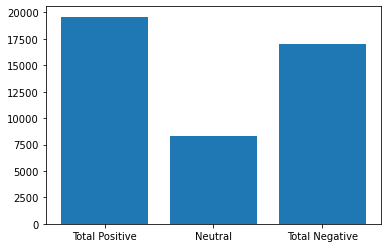

In [20]:
plt.bar(tt_label, tt)
plt.show()

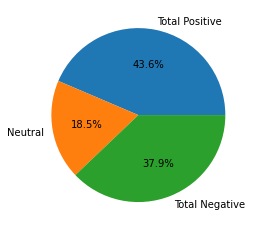

In [21]:
plt.pie(tt, labels=tt_label, autopct='%1.1f%%')
plt.show()

In [22]:
sentiment_count = data['Sentiment'].value_counts()
sentiment_count

Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64

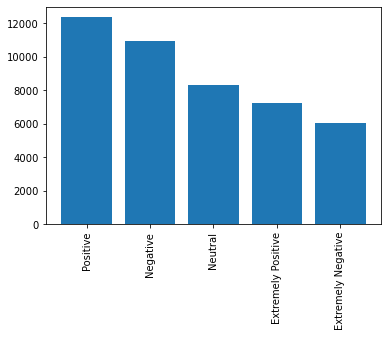

In [23]:
#plot
plt.bar(sentiment_count.index,sentiment_count)
plt.xticks(rotation=90)
plt.show()

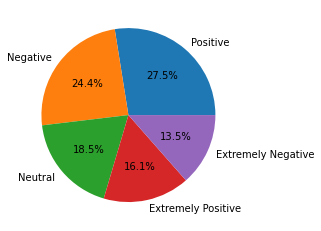

In [24]:
#plot
plt.pie(sentiment_count, labels=sentiment_count.index, autopct='%1.1f%%')
#plt.legend('upper right')
plt.show()

In [25]:
#time series - start of date and end date - line plot frequency of positive and negative
day_total = data['TweetAt'].unique()
print(day_total)

['16-03-2020' '17-03-2020' '18-03-2020' '19-03-2020' '20-03-2020'
 '21-03-2020' '22-03-2020' '23-03-2020' '24-03-2020' '25-03-2020'
 '26-03-2020' '27-03-2020' '28-03-2020' '29-03-2020' '30-03-2020'
 '31-03-2020' '01-04-2020' '02-04-2020' '03-04-2020' '04-04-2020'
 '05-04-2020' '06-04-2020' '07-04-2020' '08-04-2020' '09-04-2020'
 '10-04-2020' '11-04-2020' '12-04-2020' '13-04-2020' '14-04-2020'
 '02-03-2020' '03-03-2020' '04-03-2020' '05-03-2020' '06-03-2020'
 '07-03-2020' '08-03-2020' '09-03-2020' '10-03-2020' '11-03-2020'
 '12-03-2020' '13-03-2020' '14-03-2020' '15-03-2020']


In [26]:
#vectorizer:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['OriginalTweet'])
test_matrix = vectorizer.transform(test['OriginalTweet'])

In [27]:
X_train1 = train_matrix
X_test1 = test_matrix
#y_train = train['sentiment']
#y_test = test['sentiment']

In [28]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

lab = train['Sentiment']
y_train1 = le.fit_transform(lab)
y_test1 = le.fit_transform(test['Sentiment'])

# LR

In [75]:
#The model
lr = LogisticRegression(max_iter=10000)
#Training the model
lr.fit(X_train1,y_train1)
#Make predictions
predictions1 = lr.predict(X_test1)
print(predictions1[:10])

[3 4 4 2 3 3 4 2 0 4]


In [76]:
#Show the results of the predictions
lab_names = test['Sentiment'].unique()
lab_names[predictions1[:10]]

array(['Negative', 'Neutral', 'Neutral', 'Extremely Positive', 'Negative',
       'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative',
       'Neutral'], dtype=object)

In [77]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test1)
confusion_matrix(predictions1,y_test1)

array([[327,   5, 139,   7,  25],
       [  7, 365,  25,   7, 108],
       [220,  21, 580,  87, 129],
       [ 13,   8, 122, 442,  92],
       [ 25, 200, 175,  76, 593]])

In [144]:
print(classification_report(predictions1,y_test1))

              precision    recall  f1-score   support

           0       0.55      0.65      0.60       502
           1       0.61      0.71      0.66       511
           2       0.56      0.56      0.56      1038
           3       0.71      0.65      0.68       677
           4       0.63      0.56      0.59      1070

    accuracy                           0.61      3798
   macro avg       0.61      0.63      0.62      3798
weighted avg       0.61      0.61      0.61      3798



# LSTM

In [58]:
#Get Text data from the Tweet Column
corpus = data['OriginalTweet']
corpus

0       @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1       advice Talk to your neighbours family to excha...
2       Coronavirus Australia: Woolworths to give elde...
3       My food stock is not the only one which is emp...
4       Me, ready to go at supermarket during the #COV...
                              ...                        
3793    Meanwhile In A Supermarket in Israel -- People...
3794    Did you panic buy a lot of non-perishable item...
3795    Asst Prof of Economics @cconces was on @NBCPhi...
3796    Gov need to do somethings instead of biar je r...
3797    I and @ForestandPaper members are committed to...
Name: OriginalTweet, Length: 44955, dtype: object

In [59]:
#One-Hot Encoding of the labels
sentiment = pd.get_dummies(data['Sentiment'])
print(sentiment)

      Extremely Negative  Extremely Positive  Negative  Neutral  Positive
0                      0                   0         0        1         0
1                      0                   0         0        0         1
2                      0                   0         0        0         1
3                      0                   0         0        0         1
4                      1                   0         0        0         0
...                  ...                 ...       ...      ...       ...
3793                   0                   0         0        0         1
3794                   0                   0         1        0         0
3795                   0                   0         0        1         0
3796                   1                   0         0        0         0
3797                   0                   1         0        0         0

[44955 rows x 5 columns]


In [60]:
print(len(corpus))
print(len(sentiment))

44955
44955


In [61]:
#Words Tokenization
from nltk.tokenize import word_tokenize

all_words = []
for sent in corpus:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [62]:
#Extract each word while ignoring duplicates
unique_words = set(all_words)
print(len(unique_words))

107050


In [63]:
vocab_length = 101948
embedded_sentences = [one_hot(sent, vocab_length) for sent in corpus]
#print(embedded_sentences )

In [64]:
#count number of words
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [65]:
#Fill the end of each sentence with '0' so that they all have same lenght
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[ 98219  31356  51537 ...      0      0      0]
 [100721  76089   4306 ...      0      0      0]
 [ 42642  79097  90941 ...      0      0      0]
 ...
 [  3202  69775  44704 ...      0      0      0]
 [ 87121 101576   4306 ...      0      0      0]
 [  7045  35554  78579 ...      0      0      0]]


In [66]:
len(padded_sentences)

44955

In [67]:
#divide the data into Training and Testing

X_train,X_test, y_train, y_test = train_test_split(padded_sentences, sentiment, train_size=0.9, random_state=42)

In [68]:
#Build the Model 
model = Sequential()
model.add(Embedding(vocab_length, 20, input_length=length_long_sentence))
model.add(LSTM(20, return_sequences=True))
model.add(Dense(100, activation='relu'))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))

In [69]:
#compile model and show summary
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 235, 20)           2038960   
_________________________________________________________________
lstm (LSTM)                  (None, 235, 20)           3280      
_________________________________________________________________
dense (Dense)                (None, 235, 100)          2100      
_________________________________________________________________
flatten (Flatten)            (None, 23500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 117505    
Total params: 2,161,845
Trainable params: 2,161,845
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
#train the model

model.fit(X_train, y_train, epochs=15, steps_per_epoch=200, verbose=1)

Epoch 1/15
200/200 [==============================] - 48s 228ms/step - loss: 1.4506 - acc: 0.3430
Epoch 2/15
200/200 [==============================] - 45s 225ms/step - loss: 0.7344 - acc: 0.7314
Epoch 3/15
200/200 [==============================] - 44s 221ms/step - loss: 0.4652 - acc: 0.8495
Epoch 4/15
200/200 [==============================] - 44s 222ms/step - loss: 0.3299 - acc: 0.8966
Epoch 5/15
200/200 [==============================] - 43s 217ms/step - loss: 0.2526 - acc: 0.9244
Epoch 6/15
200/200 [==============================] - 46s 229ms/step - loss: 0.1953 - acc: 0.9415
Epoch 7/15
200/200 [==============================] - 43s 215ms/step - loss: 0.1585 - acc: 0.9544
Epoch 8/15
200/200 [==============================] - 51s 256ms/step - loss: 0.1388 - acc: 0.9613
Epoch 9/15
200/200 [==============================] - 42s 208ms/step - loss: 0.1092 - acc: 0.9684
Epoch 10/15
200/200 [==============================] - 48s 242ms/step - loss: 0.0901 - acc: 0.9754
Epoch 11/15
200/200

In [71]:
#Evaluate model performance
loss, accuracy = model.evaluate(padded_sentences, sentiment, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Accuracy: 95.408744


In [72]:
predictions = model.predict(X_test)

In [73]:
#Store Predictions result
pred_result = (np.argmax(predictions[:20], axis=1))

In [78]:
#Show result of predictions
print(lab_names[pred_result])

['Positive' 'Neutral' 'Neutral' 'Extremely Negative' 'Positive'
 'Extremely Positive' 'Neutral' 'Extremely Positive' 'Extremely Positive'
 'Neutral' 'Extremely Negative' 'Neutral' 'Positive' 'Extremely Positive'
 'Neutral' 'Extremely Positive' 'Positive' 'Neutral' 'Neutral' 'Positive']


# 模型应用-推文

In [165]:
tweet_clean=pd.read_excel('/Users/kejinglin/Desktop/personal/mydata/tweet_clean_sentiment.xlsx')
tweet_clean.head()

,u_nickname,u_url,m_content,m_content_url,m_content_id,m_images,m_videos,r_comment_num,g_publi,r_like_num,r_trans_num,verified,u_id,u_desc,u_fans,u_follow,u_login_time,u_area,topic_result
0,Pastor Mark Burns,https://twitter.com/pastormarkburns,Is it possible that President @realDonaldTrump...,NaN,1312427187220480000,NaN,NaN,43038,2020-10,41927,8776,1,39334221,"Husband, Father, South Carolina native,\nEntre...",148266,567,2009-05-12 04:31:45,South Carolina,3
1,Chuck Woolery,https://twitter.com/chuckwoolery,The most outrageous lies are the ones about Co...,NaN,1282499347117215745,NaN,NaN,41952,2020-07,66955,16983,1,462104542,"Hollywood Conservative, Love Connection Host, ...",563931,2367,2012-01-12 23:30:41,Texas,1
2,Dr. Saskia Popescu,https://twitter.com/SaskiaPopescu,"Stop. Calling. It. The. “China Virus"". \n\nJus...",NaN,1285684554230050817,NaN,NaN,34513,2020-07,10537,1470,1,26117944,ID Epi & infection prvntn | Asst Prof @ScharSc...,50247,886,2009-03-24 07:17:50,Phoenix & DC,5
3,ChuckGrassley,https://twitter.com/ChuckGrassley,I don’t understand why China gets upset bc we ...,NaN,1240245244169420800,NaN,NaN,34010,2020-03,24137,6355,1,10615232,U.S. Senator. Family farmer. Lifetime resident...,628280,12984,2007-11-26 23:17:02,Iowa,5
4,Barack Obama,https://twitter.com/BarackObama,We've seen all too terribly the consequences o...,NaN,1245007713387544576,NaN,NaN,34001,2020-03,331589,87307,1,813286,"Dad, husband, President, citizen.",129352049,594833,2007-03-06 06:08:25,"Washington, DC",4


In [167]:
content=tweet_clean['m_content']
content

0       Is it possible that President @realDonaldTrump...
1       The most outrageous lies are the ones about Co...
2       Stop. Calling. It. The. “China Virus". \n\nJus...
3       I don’t understand why China gets upset bc we ...
4       We've seen all too terribly the consequences o...
                              ...                        
3353    Pres Trump travels to the heartland today to e...
3354    Temple University genomic study: \n\n'All the ...
3355    There's "no evidence" that people gain immunit...
3356    These guys really think they can racism their ...
3357    Trump ordered 30-day travel ban from Europe to...
Name: m_content, Length: 3358, dtype: object

In [168]:
#Words Tokenization
from nltk.tokenize import word_tokenize

all_words = []
for sent in content:
    tokenize_word = word_tokenize(sent)
    for word in tokenize_word:
        all_words.append(word)

In [169]:
#Extract each word while ignoring duplicates
unique_words = set(all_words)
print(len(unique_words))

15597


In [170]:
vocab_length = 101948
embedded_sentences = [one_hot(sent, vocab_length) for sent in content]
#print(embedded_sentences )

In [171]:
#count number of words
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [172]:
#Fill the end of each sentence with '0' so that they all have same lenght
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[ 58561  80259  51950 ...      0      0      0]
 [ 87495   9346  16544 ...      0      0      0]
 [ 15942  78684  80259 ...      0      0      0]
 ...
 [100501  12155  40136 ...      0      0      0]
 [  1078  45656   5074 ...      0      0      0]
 [  7904  69773  41483 ...      0      0      0]]


In [173]:
len(padded_sentences)

3358

In [174]:
result=model.predict(padded_sentences)

In [175]:
result

array([[3.0864346e-06, 1.1544614e-05, 1.8970789e-01, 1.9284154e-01,
        6.1743599e-01],
       [9.9559480e-01, 3.6925972e-08, 3.6665932e-03, 8.3678839e-05,
        6.5492501e-04],
       [8.8577199e-01, 2.8782839e-07, 1.1193123e-01, 2.8524021e-06,
        2.2935430e-03],
       ...,
       [4.0887593e-07, 1.3378168e-03, 4.1481102e-01, 3.8544335e-06,
        5.8384699e-01],
       [1.0315003e-01, 6.1000321e-07, 8.9627492e-01, 1.0191595e-08,
        5.7437900e-04],
       [9.9981052e-01, 8.8927928e-11, 1.8783024e-04, 2.6626043e-11,
        1.6455405e-06]], dtype=float32)

In [176]:
pred_result = (np.argmax(result, axis=1))
pred_result

array([4, 0, 0, ..., 4, 2, 0])

In [177]:
print(lab_names[pred_result])

['Neutral' 'Extremely Negative' 'Extremely Negative' ... 'Neutral'
 'Extremely Positive' 'Extremely Negative']


In [ ]:
#3:negative
#0:emtremly naglitive
#2:extremly positive
#4:netural
#1:positive

In [178]:
write_result=pd.DataFrame(pred_result)

In [179]:
write_result.to_excel('/Users/kejinglin/Desktop/personal/mydata/sentiment_result_lstm.xls',)

In [184]:
sentiment=pd.read_excel('/Users/kejinglin/Desktop/personal/mydata/sentiment_result_lstm.xls')
sentiment.head()

,Unnamed: 0,sentiment
0,0,4
1,1,0
2,2,0
3,3,0
4,4,2


In [185]:
sentiment.loc[:,'sentiment'].value_counts()

2    1104
0     751
4     734
3     418
1     351
Name: sentiment, dtype: int64

# 模型应用-评论

In [103]:
import pandas as pd
import numpy as np
import re

dtype={
      'verified':str
       }   

comment = pd.read_excel('/Users/lin/Desktop/personal/mydata/clean_comment.xlsx',dtype=dtype)
comment.head(5)

,Unnamed: 0,m_origin_id,u_id,r_id,r_content,g_publish_time,u_nickname,u_url,u_introduction,r_follow_num,r_fans_num,verified,u_login_time,u_area,name_binary,description_binary,location_binary,url_binary,result
0,0,1043334390850510976,24928470,1044083498854896000,"@1DLowther @dcpoll @CNN Not tht I know of,",2018-09-24 12:37:58,yvonne,https://twitter.com/animalfriend1,"Veterinary Professional,animal supporter,Scien...",2693,2089,0,2009-03-18 02:37:59,Fl,False,False,True,True,True
1,1,1043334390850510976,140166872,1043367165749916032,@BabyD_Rae @dcpoll @power2she @CNN They don't ...,2018-09-22 13:11:31,immigration detention = $770/night squalor,https://twitter.com/pookietooth,"gov't should regulate co's & protect us, not p...",8305,7332,0,2010-05-05 03:41:28,United States,False,False,True,True,True
2,2,1043334390850510976,308698101,1043353604499955968,@DwayneRude1 @dcpoll @CNN LMFAOOOOOOOOOOOO,2018-09-22 12:17:38,❄VerySpecialSnowFlake❄,https://twitter.com/miamidecor,Snowflake in Miami,7900,7028,0,2011-06-01 05:06:40,Stalking Zimmerman,False,False,True,True,True
3,3,1043334390850510976,831816535,1043340238893068032,@Enrico056 @dcpoll @CNN @GOP @ChuckGrassley Th...,2018-09-22 11:24:31,Patty Harbison,https://twitter.com/PattyHarbison,"#TodaysHaiku Retired lawyer, HLS alum. Wife to...",964,1291,0,2012-09-19 04:20:37,Middle TN,False,False,True,True,True
4,4,1043334390850510976,833728731504013312,1043344963507868032,@KitchyItchy @dcpoll @CNN His weird little fla...,2018-09-22 11:43:18,A Middle Aged Lady in a Flyover State,https://twitter.com/AFlyover,I've installed a Xanax Salt Lick in every room...,4270,4205,0,2017-02-21 01:23:14,Middle of Nowhere,False,True,True,True,True


In [104]:
comment.describe()

,Unnamed: 0,m_origin_id,u_id,r_id,r_follow_num,r_fans_num
count,516443.000000,5.164430e+05,5.164430e+05,5.164430e+05,5.164430e+05,5.164430e+05
mean,270909.943119,1.268973e+18,4.572684e+17,1.269424e+18,1.628638e+03,3.562466e+04
std,156291.479106,4.270278e+16,5.320254e+17,4.066292e+16,7.056354e+03,8.020162e+05
min,0.000000,2.681472e+17,1.200000e+01,1.938526e+17,0.000000e+00,0.000000e+00
25%,135641.000000,1.242449e+18,3.040813e+08,1.242629e+18,1.990000e+02,7.000000e+01
50%,270757.000000,1.253447e+18,2.960705e+09,1.253768e+18,5.280000e+02,2.570000e+02
75%,405946.500000,1.293768e+18,1.023689e+18,1.294310e+18,1.415000e+03,1.071000e+03
max,542621.000000,1.360644e+18,1.360270e+18,1.362888e+18,1.604839e+06,1.293520e+08


In [114]:
comm=comment['u_introduction']
comm

0         Veterinary Professional,animal supporter,Scien...
1         gov't should regulate co's & protect us, not p...
2                                        Snowflake in Miami
3         #TodaysHaiku Retired lawyer, HLS alum. Wife to...
4         I've installed a Xanax Salt Lick in every room...
                                ...                        
516438                        kattar congressi... ❤RG & SG❤
516439                                                  NaN
516440    Rajya Sabha MP, Fmr. Union Cabinet Minister, H...
516441                                                  NaN
516442    history enthusiast by passion;\nthree decades ...
Name: u_introduction, Length: 516443, dtype: object

In [110]:
#Words Tokenization
from nltk.tokenize import word_tokenize

all_words = []
for sent in comm:
    tokenize_word = word_tokenize(str(sent))
    for word in tokenize_word:
        all_words.append(word)

In [111]:
#Extract each word while ignoring duplicates
unique_words = set(all_words)
print(len(unique_words))

296327


In [116]:
vocab_length = 101948
embedded_sentences = [one_hot(str(sent), vocab_length) for sent in comm]
#print(embedded_sentences )

In [117]:
#count number of words
word_count = lambda sentence: len(word_tokenize(sentence))
longest_sentence = max(corpus, key=word_count)
length_long_sentence = len(word_tokenize(longest_sentence))

In [118]:
#Fill the end of each sentence with '0' so that they all have same lenght
padded_sentences = pad_sequences(embedded_sentences, length_long_sentence, padding='post')
print(padded_sentences)

[[60283 90883  4092 ...     0     0     0]
 [13954 99401 47775 ...     0     0     0]
 [98359 40925 22761 ...     0     0     0]
 ...
 [80306 36954 11586 ...     0     0     0]
 [65876     0     0 ...     0     0     0]
 [92162  4559 59355 ...     0     0     0]]


In [119]:
len(padded_sentences)

516443

In [120]:
result2=model.predict(padded_sentences)

In [121]:
pred_result2 = (np.argmax(result2, axis=1))
pred_result2

array([1, 4, 3, ..., 4, 3, 3])

In [126]:
counts = pd.value_counts(pred_result2)
counts

3    260843
4    117487
2     69514
1     52797
0     15802
dtype: int64

In [ ]:
#3:negative
#0:emtremly naglitive
#2:extremly positive
#4:netural
#1:positive

In [159]:
comment['sentiment']=pd.DataFrame(pred_result2)

In [160]:
comment.head()

,Unnamed: 0,m_origin_id,u_id,r_id,r_content,g_publish_time,u_nickname,u_url,u_introduction,r_follow_num,r_fans_num,verified,u_login_time,u_area,name_binary,description_binary,location_binary,url_binary,result,sentiment
0,0,1043334390850510976,24928470,1044083498854896000,"@1DLowther @dcpoll @CNN Not tht I know of,",2018-09-24 12:37:58,yvonne,https://twitter.com/animalfriend1,"Veterinary Professional,animal supporter,Scien...",2693,2089,0,2009-03-18 02:37:59,Fl,False,False,True,True,True,1
1,1,1043334390850510976,140166872,1043367165749916032,@BabyD_Rae @dcpoll @power2she @CNN They don't ...,2018-09-22 13:11:31,immigration detention = $770/night squalor,https://twitter.com/pookietooth,"gov't should regulate co's & protect us, not p...",8305,7332,0,2010-05-05 03:41:28,United States,False,False,True,True,True,4
2,2,1043334390850510976,308698101,1043353604499955968,@DwayneRude1 @dcpoll @CNN LMFAOOOOOOOOOOOO,2018-09-22 12:17:38,❄VerySpecialSnowFlake❄,https://twitter.com/miamidecor,Snowflake in Miami,7900,7028,0,2011-06-01 05:06:40,Stalking Zimmerman,False,False,True,True,True,3
3,3,1043334390850510976,831816535,1043340238893068032,@Enrico056 @dcpoll @CNN @GOP @ChuckGrassley Th...,2018-09-22 11:24:31,Patty Harbison,https://twitter.com/PattyHarbison,"#TodaysHaiku Retired lawyer, HLS alum. Wife to...",964,1291,0,2012-09-19 04:20:37,Middle TN,False,False,True,True,True,1
4,4,1043334390850510976,833728731504013312,1043344963507868032,@KitchyItchy @dcpoll @CNN His weird little fla...,2018-09-22 11:43:18,A Middle Aged Lady in a Flyover State,https://twitter.com/AFlyover,I've installed a Xanax Salt Lick in every room...,4270,4205,0,2017-02-21 01:23:14,Middle of Nowhere,False,True,True,True,True,3


In [161]:
comment['sentiment'][comment['sentiment']==0]='em negative'
comment['sentiment'][comment['sentiment']==1]='positive'
comment['sentiment'][comment['sentiment']==2]='em positive'
comment['sentiment'][comment['sentiment']==3]='negative'
comment['sentiment'][comment['sentiment']==4]='netural'

<ipython-input-161-f309557c4401>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment['sentiment'][comment['sentiment']==0]='em negative'


In [162]:
comment.head()

,Unnamed: 0,m_origin_id,u_id,r_id,r_content,g_publish_time,u_nickname,u_url,u_introduction,r_follow_num,r_fans_num,verified,u_login_time,u_area,name_binary,description_binary,location_binary,url_binary,result,sentiment
0,0,1043334390850510976,24928470,1044083498854896000,"@1DLowther @dcpoll @CNN Not tht I know of,",2018-09-24 12:37:58,yvonne,https://twitter.com/animalfriend1,"Veterinary Professional,animal supporter,Scien...",2693,2089,0,2009-03-18 02:37:59,Fl,False,False,True,True,True,positive
1,1,1043334390850510976,140166872,1043367165749916032,@BabyD_Rae @dcpoll @power2she @CNN They don't ...,2018-09-22 13:11:31,immigration detention = $770/night squalor,https://twitter.com/pookietooth,"gov't should regulate co's & protect us, not p...",8305,7332,0,2010-05-05 03:41:28,United States,False,False,True,True,True,netural
2,2,1043334390850510976,308698101,1043353604499955968,@DwayneRude1 @dcpoll @CNN LMFAOOOOOOOOOOOO,2018-09-22 12:17:38,❄VerySpecialSnowFlake❄,https://twitter.com/miamidecor,Snowflake in Miami,7900,7028,0,2011-06-01 05:06:40,Stalking Zimmerman,False,False,True,True,True,negative
3,3,1043334390850510976,831816535,1043340238893068032,@Enrico056 @dcpoll @CNN @GOP @ChuckGrassley Th...,2018-09-22 11:24:31,Patty Harbison,https://twitter.com/PattyHarbison,"#TodaysHaiku Retired lawyer, HLS alum. Wife to...",964,1291,0,2012-09-19 04:20:37,Middle TN,False,False,True,True,True,positive
4,4,1043334390850510976,833728731504013312,1043344963507868032,@KitchyItchy @dcpoll @CNN His weird little fla...,2018-09-22 11:43:18,A Middle Aged Lady in a Flyover State,https://twitter.com/AFlyover,I've installed a Xanax Salt Lick in every room...,4270,4205,0,2017-02-21 01:23:14,Middle of Nowhere,False,True,True,True,True,negative


In [164]:
comment['sentiment'].replace({"em negative": 0, "negative": 1,'netural':2,'positive':3,'em positive':4}, inplace=True)

In [165]:
comment.head()

,Unnamed: 0,m_origin_id,u_id,r_id,r_content,g_publish_time,u_nickname,u_url,u_introduction,r_follow_num,r_fans_num,verified,u_login_time,u_area,name_binary,description_binary,location_binary,url_binary,result,sentiment
0,0,1043334390850510976,24928470,1044083498854896000,"@1DLowther @dcpoll @CNN Not tht I know of,",2018-09-24 12:37:58,yvonne,https://twitter.com/animalfriend1,"Veterinary Professional,animal supporter,Scien...",2693,2089,0,2009-03-18 02:37:59,Fl,False,False,True,True,True,3
1,1,1043334390850510976,140166872,1043367165749916032,@BabyD_Rae @dcpoll @power2she @CNN They don't ...,2018-09-22 13:11:31,immigration detention = $770/night squalor,https://twitter.com/pookietooth,"gov't should regulate co's & protect us, not p...",8305,7332,0,2010-05-05 03:41:28,United States,False,False,True,True,True,2
2,2,1043334390850510976,308698101,1043353604499955968,@DwayneRude1 @dcpoll @CNN LMFAOOOOOOOOOOOO,2018-09-22 12:17:38,❄VerySpecialSnowFlake❄,https://twitter.com/miamidecor,Snowflake in Miami,7900,7028,0,2011-06-01 05:06:40,Stalking Zimmerman,False,False,True,True,True,1
3,3,1043334390850510976,831816535,1043340238893068032,@Enrico056 @dcpoll @CNN @GOP @ChuckGrassley Th...,2018-09-22 11:24:31,Patty Harbison,https://twitter.com/PattyHarbison,"#TodaysHaiku Retired lawyer, HLS alum. Wife to...",964,1291,0,2012-09-19 04:20:37,Middle TN,False,False,True,True,True,3
4,4,1043334390850510976,833728731504013312,1043344963507868032,@KitchyItchy @dcpoll @CNN His weird little fla...,2018-09-22 11:43:18,A Middle Aged Lady in a Flyover State,https://twitter.com/AFlyover,I've installed a Xanax Salt Lick in every room...,4270,4205,0,2017-02-21 01:23:14,Middle of Nowhere,False,True,True,True,True,1


In [166]:
comment_sentiment=comment.groupby(['m_origin_id']).agg({'sentiment':np.mean}).reset_index()
comment_sentiment.head()

,m_origin_id,sentiment
0,268147222116454400,1.788546
1,1043334390850510976,1.982456
2,1187829299207953920,1.683486
3,1217043229427760896,1.834101
4,1218450660989001984,1.765217


In [167]:
comment_sentiment['m_origin_id'] = comment_sentiment.apply(lambda x: '%d' % (x['m_origin_id']), axis=1).astype(str)
comment_sentiment.to_excel('/Users/lin/Desktop/personal/mydata/comment_sentiment.xlsx')